# Example notebook testing effective elastic properties calculator

Initialize

In [2]:
from context import elasticc as el
import numpy as np
import matplotlib.pyplot as plt

# Almost zero. This is needed to avoid some division by zero.
# Need a better solution
zero = 1e-12

# Set up components using values from Mainprice (1997)
# Solid phase properties
#Model SC3 Elastic Matrix (GPa) Morales et al. JGR 2018               
#Antigorite 78% Olivine 22% room pressure d=2.7292 (g/cm3)                      
#c = np.matrix([
#[97.81,33.28,27.62,0.33,0.20,-0.11],
#[33.28,159.96,45.85,-0.43,-0.49,-0.66],
#[27.62,45.85,144.48,-0.74,-2.26,-0.42],
#[0.33,-0.43,-0.74,50.19,-0.30,-0.55],
#[0.20,-0.49,-2.26,-0.30,28.47,0.07],
#[-0.11,-0.66,-0.42,-0.55,0.07,32.18]])

c11 = 136.03   # GPa
c44 = 39.86    # GPa
#c12 = 56.31    # GPa
c12 = c11-2*c44 

c = np.matrix([
[c11,c12,c12,0.0,0.0,0.0],
[c12,c11,c12,0.0,0.0,0.0],
[c12,c12,c11,0.0,0.0,0.0],
[0.0,0.0,0.0,c44,0.0,0.0],
[0.0,0.0,0.0,0.0,c44,0.0],
[0.0,0.0,0.0,0.0,0.0,c44]])

ro1 = 2.7292     # kg/m^3

#K1 = (c11+2*c12)/3.0
K1 = (c[0,0]+c[1,1]+c[2,2]+2*(c[0,1]+c[0,2]+c[1,2]))/9
G1 = c[3,3]

print(K1,G1)
# Melt phase properties
#Alkali Olivine Basalt (GPa) 1200C d=2.70 gram/cm3            
#Murase and McBirney 1973                                 
#  1.0000  1.0000  1.0000 90.0000 90.0000 90.00001
#  14.91  14.91  14.91  0.00  0.00  0.00
#  14.91  14.91  14.91  0.00  0.00  0.00
#  14.91  14.91  14.91  0.00  0.00  0.00
#   0.00   0.00   0.00  0.00  0.00  0.00
#   0.00   0.00   0.00  0.00  0.00  0.00
#   0.00   0.00   0.00  0.00  0.00  0.00
ro2 = 2.7     # Kg/m^3
K2 = 1.491e1   # GPa
G2 = zero      # GPa
print(K2,G2)

# Seismic velocities
Vp1 = np.sqrt((K1+4.0/3.0*G1)/ro1)
Vs1 = np.sqrt(G1/ro1)
Vp2 = np.sqrt((K2+4.0/3.0*G2)/ro2)
Vs2 = np.sqrt(G2/ro2)

print (Vp1,Vs1)
print(Vs1,Vs2)

dir(el)


82.88333333333334 39.86
14.91 1e-12
7.059918177460096 3.821650488710749
3.821650488710749 6.085806194501845e-07


['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'constants',
 'eep',
 'limits',
 'utils']

In [3]:
# Initialize volume fractions (melt fraction from 0 to 1)
dc = 1e-2
nc = int(1./dc-1)
c2 = np.linspace(dc,dc*nc,nc)
c1 = 1-c2

# Calculate density of composite as function of melt fraction
roe = el.limits.Voigt(ro1,c1,ro2,c2)

# General bounds

In [4]:
# Reuss bounds
Kr = el.limits.Reuss(K1,c1,K2,c2)
Gr = el.limits.Reuss(K1,c1,K2,c2)
Vpr = np.sqrt((Kr+4.0/3.0*Gr)/roe)
Vsr = np.sqrt(Gr/roe)

# Voight
Kv = el.limits.Voigt(K1,c1,K2,c2)
Gv = el.limits.Voigt(K1,c1,K2,c2)
Vpv = np.sqrt((Kv+4.0/3.0*Gv)/roe)
Vsv = np.sqrt(Gv/roe)

# Hashin-Shtrikman
Khs1,Ghs1 = el.limits.hs_bounds(K1,K2,G1,G2,c1,c2)
Khs2,Ghs2 = el.limits.hs_bounds(K2,K1,G2,G1,c2,c1)
Vphs1 = np.sqrt((Khs1+4.0/3.0*Ghs1)/roe)
Vshs1 = np.sqrt(Ghs1/roe)
Vphs2 = np.sqrt((Khs2+4.0/3.0*Ghs2)/roe)
Vshs2 = np.sqrt(Ghs2/roe)


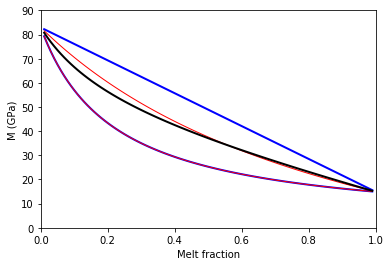

In [17]:
# Plot bounds
pmin=0
pmax=1

fig = plt.figure()
plt.xlabel('Melt fraction')
plt.ylabel('M (GPa)')
plt.xlim(pmin,pmax)
plt.ylim(0,90)

plt.plot(c2,Khs1,lw='1',c='r')
plt.plot(c2,Kv,lw='2',c='b')
plt.plot(c2,Kr,lw='2',c='b')
plt.plot(c2,Khs2,lw='1',c='r')

# Voigt-Reuss-Hill average
plt.plot(c2,(Kr+Kv)/2,lw='2',c='k')

plt.show()

# Test symmetric self consistent approximation as described by Berryman (1980)

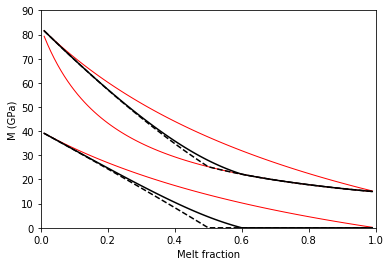

In [5]:
# Aspect ratio of two phases
a1=1.0
a2=1.0
# Unrelaxed, high frequency limit
b_Ku1,b_Gu1 = el.eep.mod_b(K1,K2,G1,G2,a1,a2,c1,c2)
b_Vpu1=np.sqrt((b_Ku1+4.0/3.0*b_Gu1)/roe)
b_Vsu1=np.sqrt(b_Gu1/roe)
# Relaxed, low frequency limit
# Calculate dry moduli first (void fill)
K,G = el.eep.mod_b(K1,0.0,G1,0.0,a1,a2,c1,c2)
# Then use Gassman's fluid substitution
b_Kr1,b_Gr1 = el.eep.gassman_2(K,G,K1,G1,K2,G2,c2)
b_Vpr1=np.sqrt((b_Kr1+4.0/3.0*b_Gr1)/roe)
b_Vsr1=np.sqrt(b_Gr1/roe)

pmin=0.0
pmax=1.0
fig = plt.figure()
plt.xlabel('Melt fraction')
plt.ylabel('M (GPa)')
plt.xlim(pmin,pmax)
plt.ylim(0,90)
plt.plot(c2,Khs1,lw='1',c='r')
plt.plot(c2,Khs2,lw='1',c='r')
plt.plot(c2,Ghs1,lw='1',c='r')
plt.plot(c2,Ghs2,lw='1',c='r')
# Plot unrelaxed bulk modulus
plt.plot(c2,b_Ku1,c='black',linewidth=1.5)
# Plot relaxed bulk modulus - dashed
plt.plot(c2,b_Kr1,c='black',linestyle='--',linewidth=1.5)
# Plot unrelaxed shear modulus
plt.plot(c2,b_Gu1,c='black',linewidth=1.5)
# Plot relaxed shear modulus - dashed
plt.plot(c2,b_Gr1,c='black',linestyle='--',linewidth=1.5)
plt.show()

# Test differential effective medium approximation

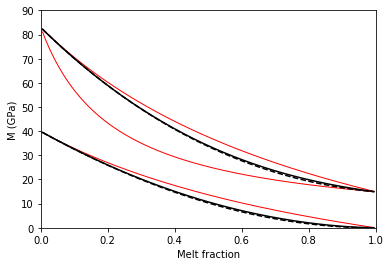

In [14]:
# Aspect ratio of two phases
a2=1.0
# Unrelaxed, high frequency limit
a_Ku1,a_Gu1 = el.eep.dem(K1,K2,G1,G2,a2,c2)
a_Vpu1=np.sqrt((a_Ku1+4.0/3.0*a_Gu1)/roe)
a_Vsu1=np.sqrt(a_Gu1/roe)
# Relaxed, low frequency limit
# Calculate dry moduli first (void fill)
K,G = el.eep.dem(K1,0.0,G1,0.0,a2,c2)
# Then use Gassman's fluid substitution
a_Kr1,a_Gr1 = el.eep.gassman_2(K,G,K1,G1,K2,G2,c2)
a_Vpr1=np.sqrt((a_Kr1+4.0/3.0*a_Gr1)/roe)
a_Vsr1=np.sqrt(a_Gr1/roe)

pmin=0
pmax=1
fig = plt.figure()
plt.xlabel('Melt fraction')
plt.ylabel('M (GPa)')
plt.xlim(pmin,pmax)
plt.ylim(0,90)
plt.plot(c2,Khs1,lw='1',c='r')
plt.plot(c2,Khs2,lw='1',c='r')
plt.plot(c2,Ghs1,lw='1',c='r')
plt.plot(c2,Ghs2,lw='1',c='r')
plt.plot(c2,a_Ku1,c='black',linewidth=1.5)
plt.plot(c2,a_Kr1,c='black',linestyle='--',linewidth=1.5)
plt.plot(c2,a_Gu1,c='black',linewidth=1.5)
plt.plot(c2,a_Gr1,c='black',linestyle='--',linewidth=1.5)
plt.show()